# Overview:
Imported data from the previous step and conducted analysis to make forest plot.


# Steps:
1. Import data
2. Conduct analysis
    * using the `metafor` package
    * using the `rma` random effects model function
    * got summary statistics
      * Heterogeneity
      * Overall effect size
      * Confidence interval
      * P-value
3. Make forest plot
4. Calculate the pooled odds ratio

In [112]:
# read in the processed data from the previous notebook
data <- read.csv("processed-data.csv")

# show the first few rows of the data
head(data)

,X.1,Article_ID,Article_Code,Total_Cohort,Measure_Name,Measure_Value,X95_CI_lower,X95_CI_upper,N1_Cancer,N2_No_Cancer,...,n,OR,study_id,odds_ratio,lower_ci,upper_ci,article_id,cancer_type,cancer_group,exclude_from_overall_plot
,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,...,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,1,"Di Luccia, 2010",D.10,"1,216",OR,3.04,1.22,7.57,0,0,...,1216,3.04,"Di Luccia, 2010",3.04,1.22,7.57,"Di Luccia, 2010",Melanoma,SKIN,
2,2,"Brewster, 2010",B.10,"77,518",SIR,1.40,0.17,5.04,0,0,...,77518,1.40,"Brewster, 2010",1.40,0.17,5.04,"Brewster, 2010",Melanoma,SKIN,
3,3,"Brewster, 2010",B.10,"77,518",SIR,0.00,0.00,3.11,0,0,...,77518,0.10,"Brewster, 2010",0.10,0.00,3.11,"Brewster, 2010",Basal Cell Carcinoma,SKIN,
4,4,"Cnattingius, 1995",C.95,89,OR,7.50,1.80,31.90,0,0,...,89,7.50,"Cnattingius, 1995",7.50,1.80,31.90,"Cnattingius, 1995",Myeloid Leukemia,BLOOD,
5,5,"Bugaiaki-Shaked, 2022",B.22,"342,172",HR,1.33,0.95,1.84,0,0,...,342172,1.33,"Bugaiaki-Shaked, 2022",1.33,0.95,1.84,"Bugaiaki-Shaked, 2022",Total Malignant Morbidity,SOLID ORGAN,
6,6,"Bugaiaki-Shaked, 2022",B.22,"342,172",HR,1.09,0.92,1.30,0,0,...,342172,1.09,"Bugaiaki-Shaked, 2022",1.09,0.92,1.30,"Bugaiaki-Shaked, 2022",Total Bengin Tumors,SOLID ORGAN,


Number of rows: 41 
The overall effect size (odds ratio) is 0.9136264 with 95% confidence interval ( 0.7734544 ,  1.079201 )
Pooled odds ratio: 1.133568 
95% CI: 1.043373 - 1.231561 

Random-Effects Model (k = 41; tau^2 estimator: DL)

  logLik  deviance       AIC       BIC      AICc   
-74.2722  143.2273  152.5444  155.9715  152.8601   

tau^2 (estimated amount of total heterogeneity): 0.1164 (SE = 0.0808)
tau (square root of estimated tau^2 value):      0.3411
I^2 (total heterogeneity / total variability):   81.58%
H^2 (total variability / sampling variability):  5.43

Test for Heterogeneity:
Q(df = 40) = 217.1639, p-val < .0001

Model Results:

estimate      se     zval    pval    ci.lb   ci.ub    
 -0.0903  0.0850  -1.0630  0.2878  -0.2569  0.0762    

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



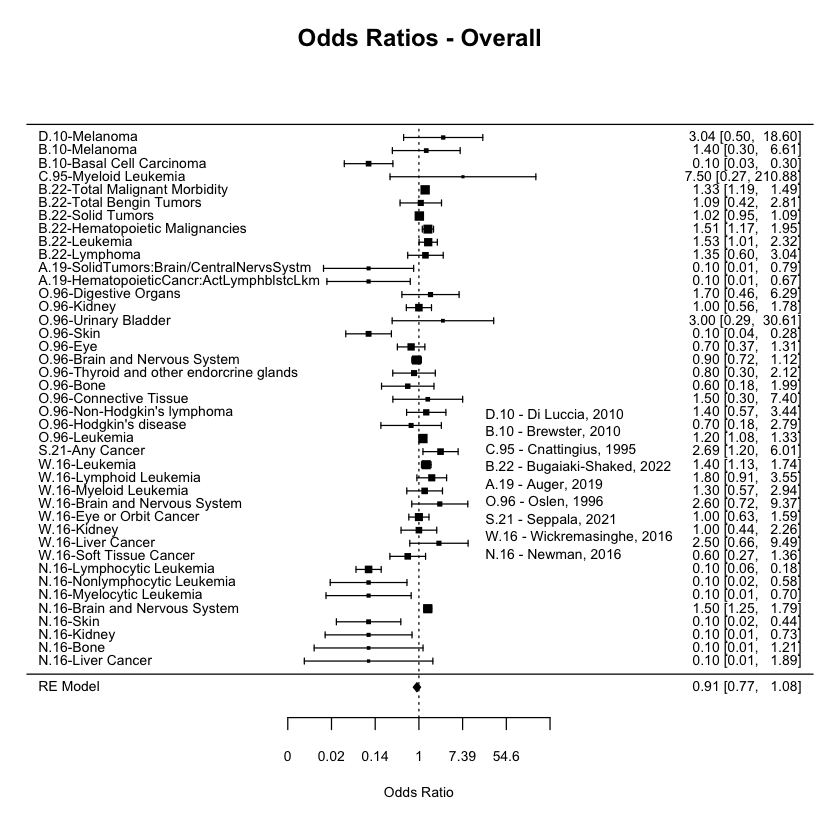

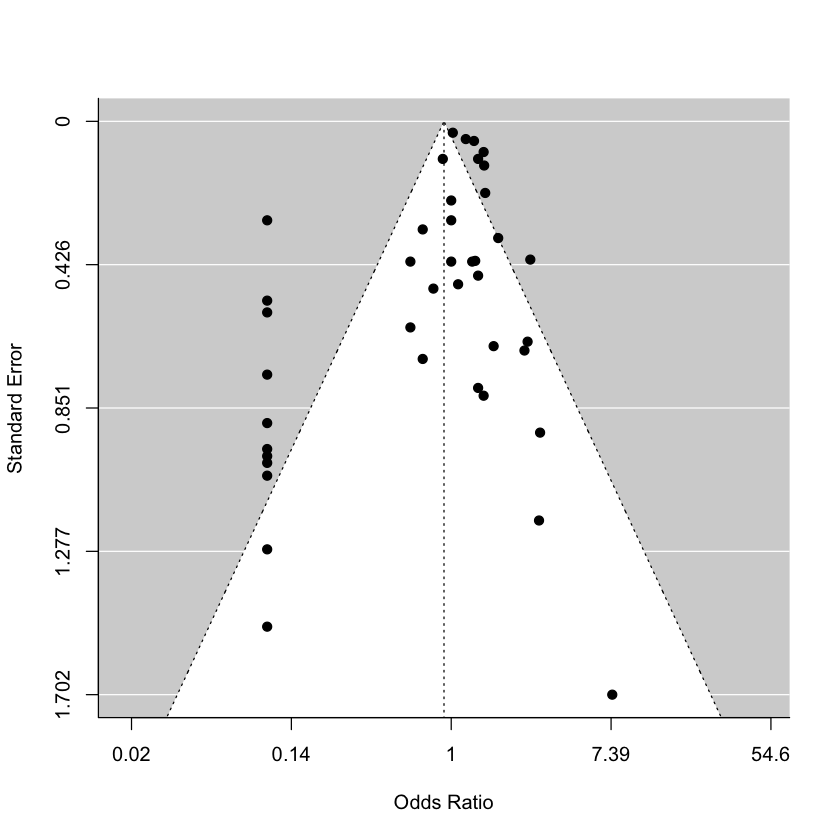

In [156]:
library(metafor)

# make the forest plot into a function that takes a data frame as input
draw_forest_and_funnel_plots <- function(dataset, groupName) {
    cat("Number of rows:", nrow(dataset), "\n")
    # create a meta-analysis object
    result <- rma(yi = log(dataset$odds_ratio), 
                    sei = log(dataset$upper_ci - dataset$lower_ci)/2, 
                    method = "DL")

    # Summarize the results
    cat("The overall effect size (odds ratio) is", 
        exp(result$b), "with 95% confidence interval (", 
        exp(result$b - 1.96 * result$se), ", ",
        exp(result$b + 1.96 * result$se), ")\n")

    # Calculate the log odds ratios and their standard errors
    log_or <- log(dataset$odds_ratio)
    se_log_or <- (log(dataset$upper_ci) - log(dataset$lower_ci)) / (2 * qnorm(0.975))

    # Calculate the weights for each study
    weights <- 1 / se_log_or^2

    # Calculate the pooled log odds ratio and its standard error
    pooled_log_or <- sum(weights * log_or) / sum(weights)
    pooled_se_log_or <- sqrt(1 / sum(weights))

    # Calculate the pooled odds ratio and its confidence interval
    pooled_or <- exp(pooled_log_or)
    lower_ci <- exp(pooled_log_or - 1.96 * pooled_se_log_or)
    upper_ci <- exp(pooled_log_or + 1.96 * pooled_se_log_or)

    # Print the results
    cat("Pooled odds ratio:", pooled_or, "\n")
    cat("95% CI:", lower_ci, "-", upper_ci, "\n")
    
    # pretty summary of the results
    print(summary(result))

    # Plot the forest plot
    forest(
        result, 
        atransf=exp, 
        xlab="Odds Ratio", 
        slab=abbreviate(paste(dataset$Article_Code, dataset$cancer_type, sep="-"), minlength = 40),
        main=paste("Odds Ratios -", groupName),
        cex=0.7,
        )
    
    # legend to show the article IDs
    legend("topright", 
           legend=paste( unique(dataset$Article_Code),unique(dataset$article_id), sep = " - "),
           cex=0.7,
           bty="n",
           text.width=1,
           inset=c(0.38,0.5)
           )

    # Plot the funnel plot
    funnel(result, atransf=exp, xlab="Odds Ratio", ylab="Standard Error")

    
}

# exclude studies that have exclude_from_overall_plot set to YES
overall_plot_data <- data[data$exclude_from_overall_plot != "YES",] 

draw_forest_and_funnel_plots(overall_plot_data, 'Overall')

Cancer Group: SKIN 
----------------------------------------------------------------
Number of rows: 6 
The overall effect size (odds ratio) is 0.38748 with 95% confidence interval ( 0.1124851 ,  1.334762 )
Pooled odds ratio: 1.559286 
95% CI: 0.7938209 - 3.062874 

Random-Effects Model (k = 6; tau^2 estimator: DL)

  logLik  deviance       AIC       BIC      AICc   
-10.8477   14.6678   25.6953   25.2788   29.6953   

tau^2 (estimated amount of total heterogeneity): 1.8532 (SE = 1.5430)
tau (square root of estimated tau^2 value):      1.3613
I^2 (total heterogeneity / total variability):   79.08%
H^2 (total variability / sampling variability):  4.78

Test for Heterogeneity:
Q(df = 5) = 23.9007, p-val = 0.0002

Model Results:

estimate      se     zval    pval    ci.lb   ci.ub    
 -0.9481  0.6310  -1.5024  0.1330  -2.1849  0.2887    

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



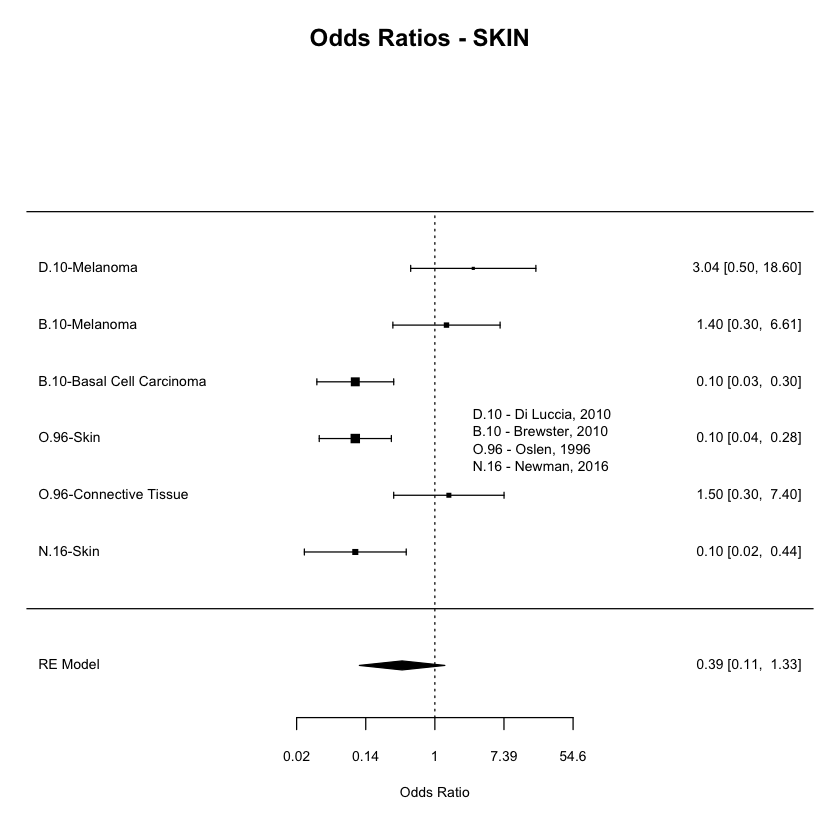

----------------------------------------------------------------
Cancer Group: BLOOD 
----------------------------------------------------------------
Number of rows: 11 
The overall effect size (odds ratio) is 0.8013259 with 95% confidence interval ( 0.527573 ,  1.217127 )
Pooled odds ratio: 0.8527986 
95% CI: 0.7350674 - 0.9893861 

Random-Effects Model (k = 11; tau^2 estimator: DL)

  logLik  deviance       AIC       BIC      AICc   
-22.0835   46.9255   48.1669   48.9627   49.6669   

tau^2 (estimated amount of total heterogeneity): 0.3077 (SE = 0.2753)
tau (square root of estimated tau^2 value):      0.5547
I^2 (total heterogeneity / total variability):   90.08%
H^2 (total variability / sampling variability):  10.08

Test for Heterogeneity:
Q(df = 10) = 100.7994, p-val < .0001

Model Results:

estimate      se     zval    pval    ci.lb   ci.ub    
 -0.2215  0.2133  -1.0386  0.2990  -0.6395  0.1965    

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



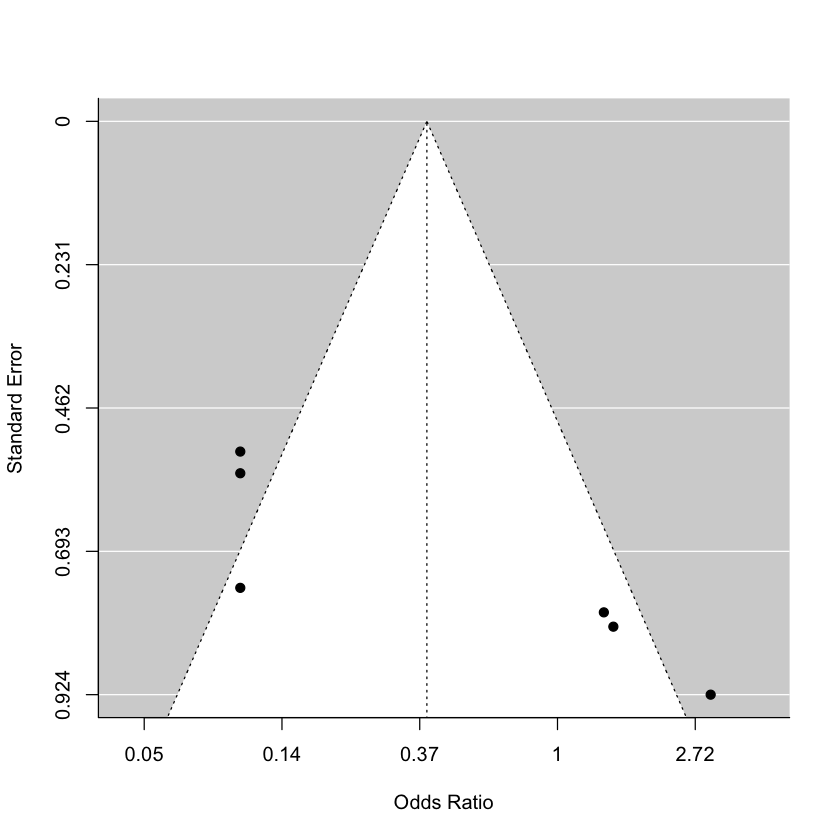

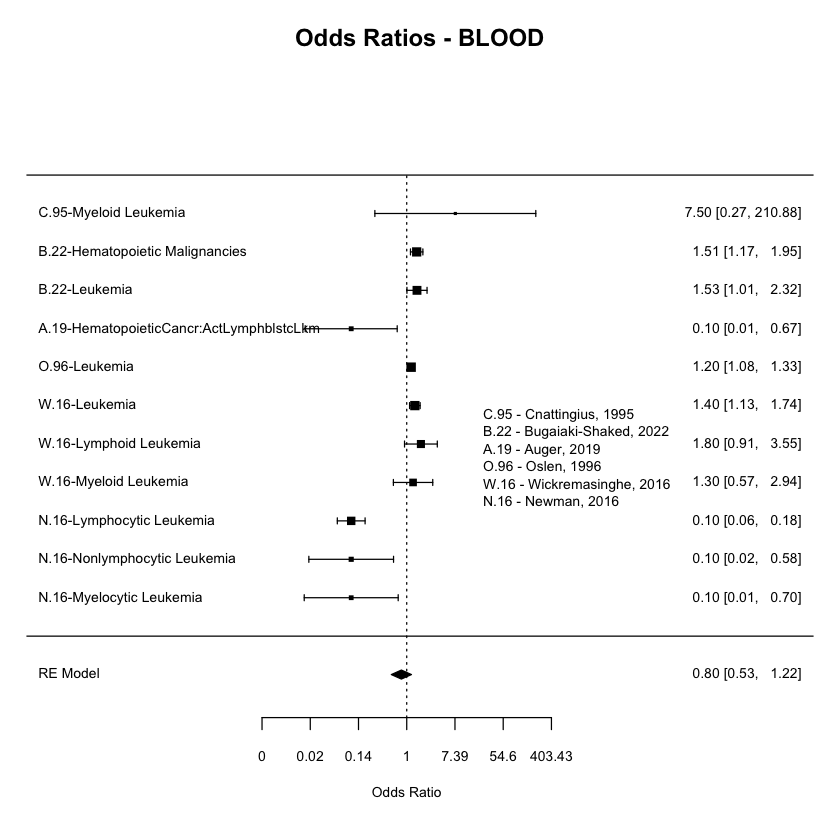

----------------------------------------------------------------
Cancer Group: SOLID ORGAN 
----------------------------------------------------------------
Number of rows: 23 
The overall effect size (odds ratio) is 1.052092 with 95% confidence interval ( 0.8946374 ,  1.237259 )
Pooled odds ratio: 0.9867256 
95% CI: 0.877211 - 1.109912 

Random-Effects Model (k = 23; tau^2 estimator: DL)

  logLik  deviance       AIC       BIC      AICc   
-21.2875   41.5839   46.5749   48.8459   47.1749   

tau^2 (estimated amount of total heterogeneity): 0.0426 (SE = 0.0404)
tau (square root of estimated tau^2 value):      0.2064
I^2 (total heterogeneity / total variability):   62.32%
H^2 (total variability / sampling variability):  2.65

Test for Heterogeneity:
Q(df = 22) = 58.3801, p-val < .0001

Model Results:

estimate      se    zval    pval    ci.lb   ci.ub    
  0.0508  0.0827  0.6139  0.5393  -0.1113  0.2129    

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



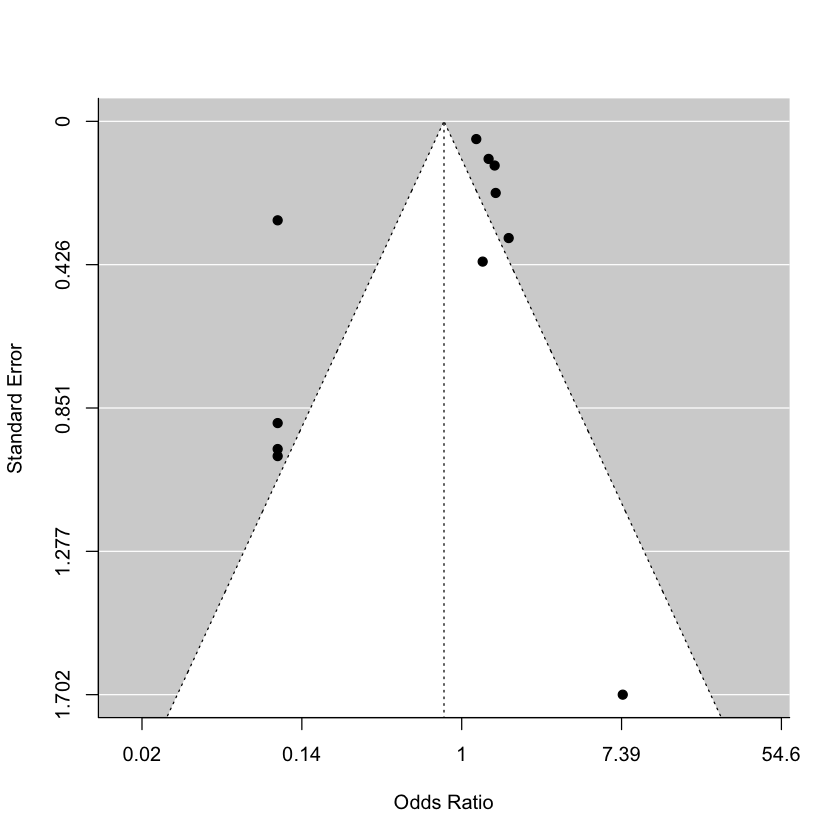

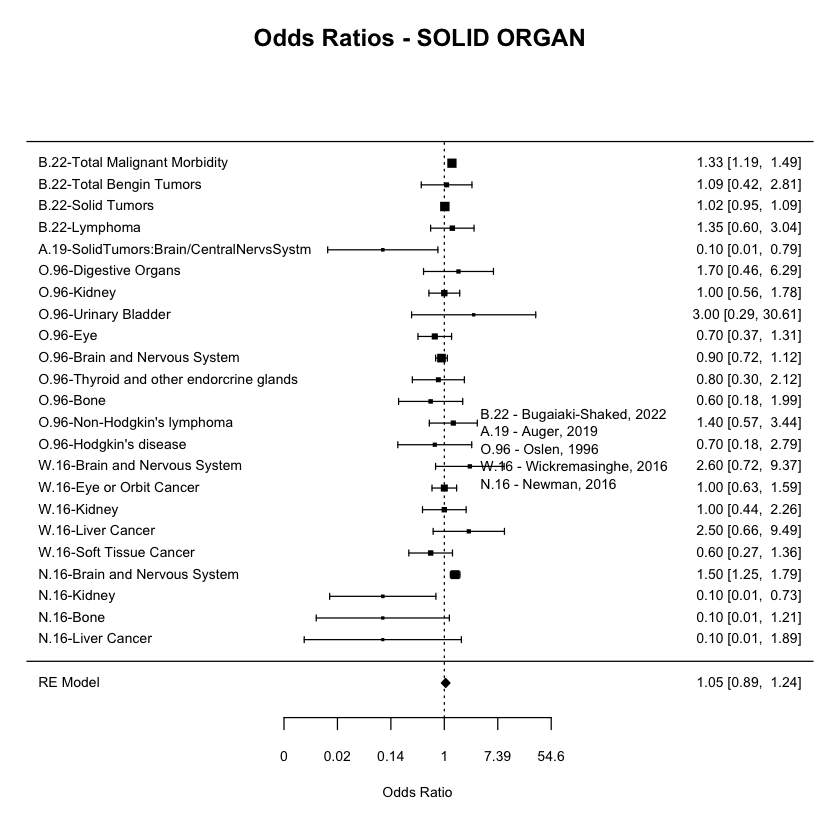

----------------------------------------------------------------
Cancer Group:  
----------------------------------------------------------------
Number of rows: 13 
The overall effect size (odds ratio) is 0.3577287 with 95% confidence interval ( 0.07964395 ,  1.606774 )
Pooled odds ratio: 0.7148014 
95% CI: 0.6511155 - 0.7847165 

Random-Effects Model (k = 13; tau^2 estimator: DL)

  logLik  deviance       AIC       BIC      AICc   
-27.3344   53.4634   58.6687   59.7986   59.8687   

tau^2 (estimated amount of total heterogeneity): 7.0669 (SE = 6.6846)
tau (square root of estimated tau^2 value):      2.6584
I^2 (total heterogeneity / total variability):   99.50%
H^2 (total variability / sampling variability):  199.10

Test for Heterogeneity:
Q(df = 12) = 2389.2050, p-val < .0001

Model Results:

estimate      se     zval    pval    ci.lb   ci.ub    
 -1.0280  0.7664  -1.3413  0.1798  -2.5302  0.4742    

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



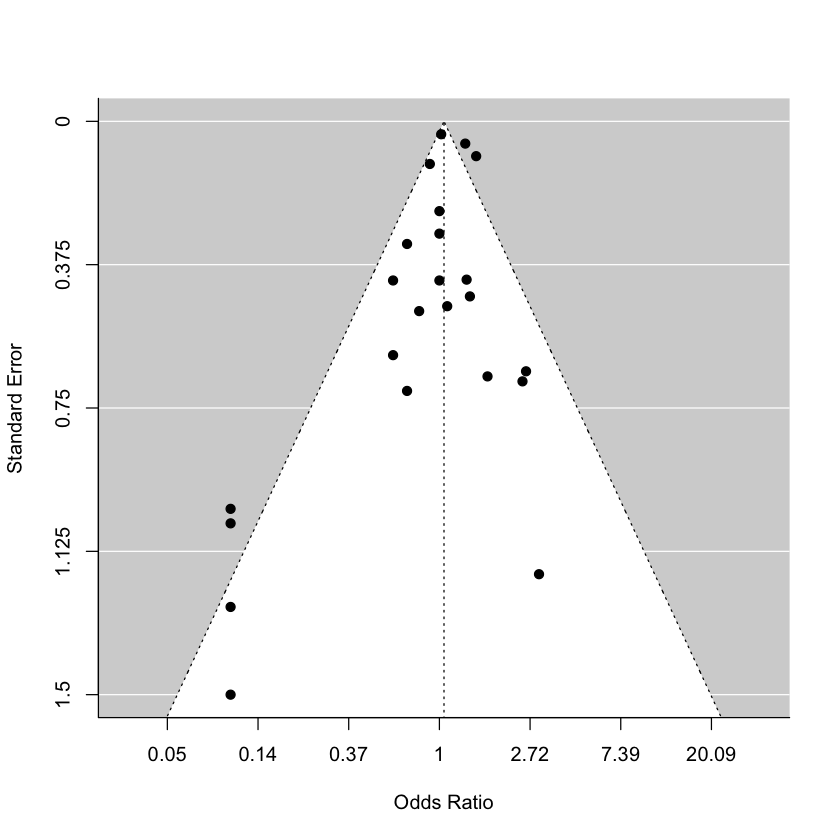

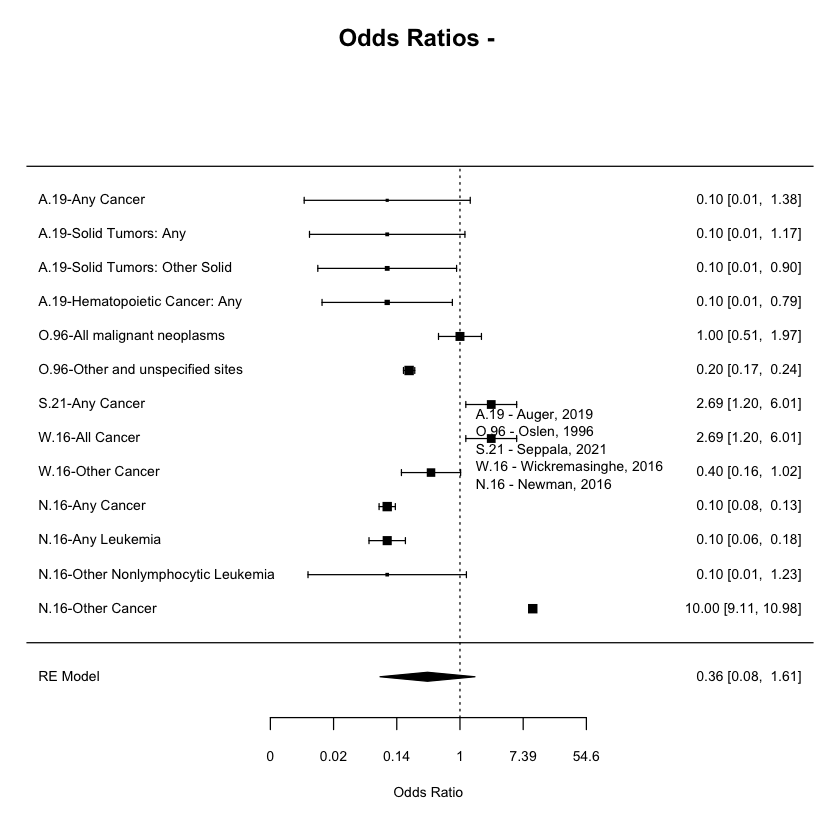

----------------------------------------------------------------


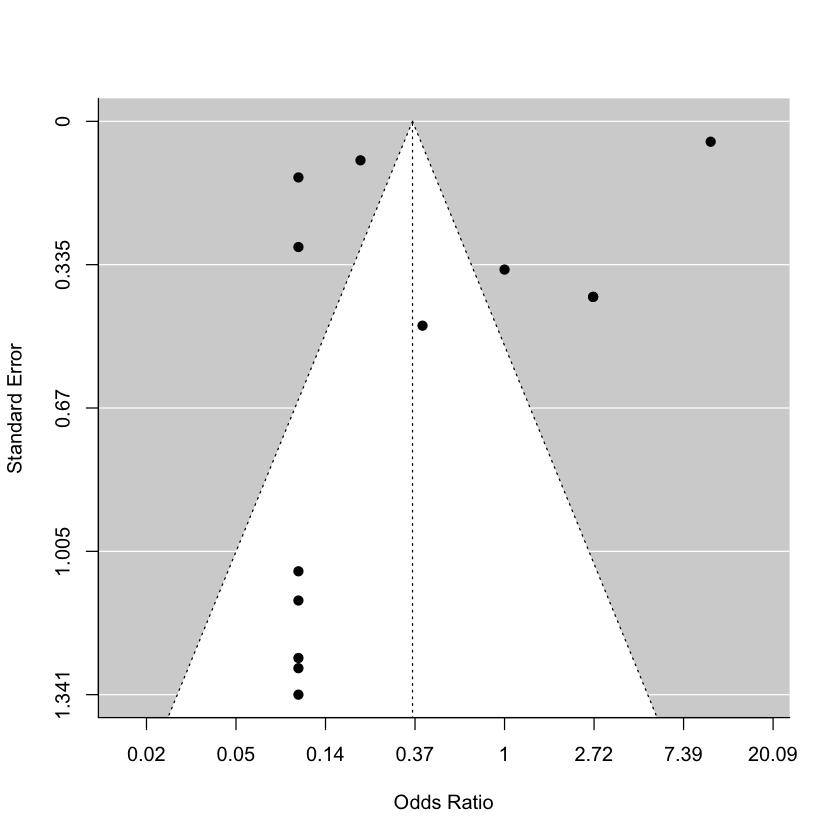

In [157]:
# subset the data by cancer type and draw the forest plot
for (cancer_group_name in unique(data$cancer_group)) {
    cat("Cancer Group:", cancer_group_name, "\n")
    cat("----------------------------------------------------------------\n")
    focus_data <- data[data$cancer_group == cancer_group_name,]
    draw_forest_and_funnel_plots(focus_data, cancer_group_name)
    # print a dotted line to separate the plots
    cat("----------------------------------------------------------------\n")
}
